# Motion Statistical Analysis
Analyzes video clips for frame to frame motion and bins the severity of motion into a histogram.

Iterate over test set and safe duv into dataframe.

- Create test loader
- Load homography estimation model from configs

In [11]:
import os
import cv2
import pandas as pd
import torch
from dotmap import DotMap
from torch.utils.data import DataLoader
from kornia import tensor_to_image, warp_perspective
import sys

sys.path.append('../')

import lightning_modules
from datasets import VideoDataset
from utils.io import load_yaml, load_pickle, save_pickle, scan2df, natural_keys
from utils.transforms import anyDictListToCompose
from utils.processing import image_edges, four_point_homography_to_matrix, frame_pairs
from utils.viz import yt_alpha_blend

# iterate over test set and safe duv into dataframe
server = 'local'
servers = load_yaml('../config/servers.yml')
server = DotMap(servers[server])

configs = 'predictive_horizon_dgx.yml'
configs = load_yaml(os.path.join(server.config.location, configs))

backbone_path = 'deep_image_homography_estimation_backbone/version_6'

# append configs by backbone
backbone_configs = load_yaml(os.path.join(server.logging.location, backbone_path, 'configs.yml'))
df = scan2df(os.path.join(server.logging.location, backbone_path, 'checkpoints'), '.ckpt')
ckpts = sorted(list(df.file), key=natural_keys)
configs['model']['homography_regression'] = {
    'lightning_module': backbone_configs['lightning_module'],
    'model': backbone_configs['model'],
    'path': backbone_path,
    'checkpoint': 'checkpoints/{}'.format(ckpts[-1]),
    'experiment': backbone_configs['experiment']
}

configs = DotMap(configs)

n_vids = 2
meta_df = pd.read_pickle(os.path.join(server.config.location, configs.data.meta_df))[configs.data.subset_length:configs.data.subset_length+n_vids]
meta_df.train = False  # artificially set to test set
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]
test_pre_transforms = [anyDictListToCompose(row.pre_transforms) for _, row in test_meta_df.iterrows()]
test_aug_transforms = [anyDictListToCompose(row.aug_transforms) for _, row in test_meta_df.iterrows()]

# load video meta data if existing, returns None if none existent
test_metadata = load_pickle(os.path.join(server.config.location, configs.data.test_metadata))
if test_metadata is not None:
    if len(test_metadata['video_paths']) == 0:
        test_metadata = None

# create video dataset and dataloader
clip_length_in_frames = 8
frame_rate = 5
frames_between_clips = clip_length_in_frames - 1
precomputed_metadata = test_metadata
num_workers = 8
pre_transforms = test_pre_transforms
aug_transforms = test_aug_transforms
seeds = True

vid_ds = VideoDataset(
    video_paths=test_video_paths,
    clip_length_in_frames=clip_length_in_frames,
    frames_between_clips=frames_between_clips,
    frame_rate=frame_rate,
    precomputed_metadata=test_metadata,
    num_workers=num_workers,
    pre_transforms=pre_transforms,
    aug_transforms=aug_transforms,
    seeds=seeds
)

# save metadata
if test_metadata is None:
    save_pickle(os.path.join(configs.data.test_metadata), vid_ds.metadata)

batch_size = 2
drop_last = True

vid_dl = DataLoader(
    vid_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=drop_last
)

# load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Running on {}'.format(device))
torch.set_grad_enabled(False)
homography_regression = getattr(lightning_modules, configs.model.homography_regression.lightning_module).load_from_checkpoint(
    checkpoint_path=os.path.join(server.logging.location, configs.model.homography_regression.path, configs.model.homography_regression.checkpoint),
    **configs.model
)
homography_regression.to(device).eval()

# run inference and log duvs with corresponding vid and frame index
log_df = pd.DataFrame(columns=['vid_idx', 'clip_idx', 'duv', 'uv', 'H'])

log_df.attrs = {
    'clip_length_in_frames': clip_length_in_frames,
    'frame_rate': frame_rate,
    'frames_between_clips': frames_between_clips,
    'meta_data': vid_ds.metadata
}

cnt = 0

for batch_idx, batch in enumerate(vid_dl):
    vids, aug_vids, re_sample_frame_rates, frame_rates, vid_idc, clip_idc = batch
    print('\rBatch: {}/{}, BxNxCxHxW: {}, Video/Frame Idices: {}/{}'.format(batch_idx + 1, len(vid_dl), list(vids.shape), vid_idc.numpy().tolist(), clip_idc.numpy().tolist()), end='')

    vids = vids.to(device)

    frames_i, frames_ips = frame_pairs(vids, 1)

    frames_i   = frames_i.reshape((-1,) + frames_i.shape[-3:])      # BxNxCxHxW -> B*NxCxHxW
    frames_ips = frames_ips.reshape((-1,) + frames_ips.shape[-3:])  # BxNxCxHxW -> B*NxCxHxW
    duvs = homography_regression(frames_i, frames_ips)

    frames_i   = frames_i.view((batch_size,-1,) + frames_i.shape[-3:])      # B*NxCxHxW -> BxNxCxHxW
    frames_ips = frames_ips.view((batch_size,-1,) + frames_ips.shape[-3:])  # B*NxCxHxW -> BxNxCxHxW

    duvs = duvs.view(batch_size, -1, 4, 2)  # reshape B*Nx4x2 -> BxNx4x2

    # iterate batch
    for sample_idx in range(batch_size):
        uvs = image_edges(frames_i[sample_idx])     
        Hs = four_point_homography_to_matrix(uvs, duvs[sample_idx])

        # iterate sequence
        for duv, uv, H in zip(duvs[sample_idx], uvs, Hs):
            log = {
                'vid_idx': vid_idc[sample_idx].cpu().item(),
                'clip_idx': clip_idc[sample_idx].cpu().item(),
                'duv': duv.cpu().numpy(),
                'uv': uv.cpu().numpy(),
                'H': H.cpu().numpy()
            }
            
            log_df = log_df.append(log, ignore_index=True)

#         # viz
#         wrps = warp_perspective(frames_i[sample_idx], torch.inverse(Hs), frames_i.shape[-2:])
#         blends = yt_alpha_blend(frames_ips[sample_idx], wrps)

#         for blend in blends:
#             cv2.imshow('blend', tensor_to_image(blend))
#             cv2.waitKey()

# cv2.destroyAllWindows()

# log results
log_df.to_pickle('frame_to_frame_homography_regression_n_vids_{}.pkl'.format(n_vids))
log_df


RuntimeError: Failed to load /home/martin/Documents/code_snippets/homography_imitation_learning/config/test_metadata.pkl

 - Analyze the distribution of motion

,vid_idx,clip_idx,duv,uv,H,duv_mpd,duv_mpd_ravg
0,0,-9,"[[-0.49458757, -51.78722], [-5.618288, -49.223...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.99140865, 0.0155427335, -51.78722], [-0.00...",52.294498,NaN
1,0,-9,"[[11.599631, -27.653551], [-48.654926, -75.644...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.7664413, -0.015599584, -27.653551], [-0.08...",55.174454,NaN
2,0,-9,"[[-20.12877, -58.74235], [-33.617252, -32.5716...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.9901411, 0.015226443, -58.74235], [-0.0182...",58.123840,NaN
3,0,-9,"[[13.443927, 2.2622604], [9.863069, -3.9509685...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.9855226, -0.0071408907, 2.2622604], [-0.00...",16.154755,NaN
4,0,-9,"[[7.773476, -9.496775], [7.3994045, -9.935021]...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[1.0141823, -0.010834789, -9.496775], [-0.000...",19.412405,NaN
...,...,...,...,...,...,...,...
78535,5,11210,"[[-19.411848, -61.210617], [-15.582313, 9.4623...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[1.1034079, 0.09121046, -61.210617], [0.00615...",30.164558,35.105438
78536,5,11210,"[[30.923824, -37.432476], [24.131306, -35.1533...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.908401, 0.01560336, -37.432476], [-0.01440...",41.908112,34.396954
78537,5,11210,"[[34.85017, 3.5773947], [-13.76417, 9.806058],...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.818031, 0.0030380646, 3.5773947], [-0.0718...",25.803474,31.988377
78538,5,11210,"[[-0.9744975, 2.3105974], [-11.902874, 10.4679...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.94819677, 0.047740027, 2.3105974], [-0.015...",25.744980,29.356046


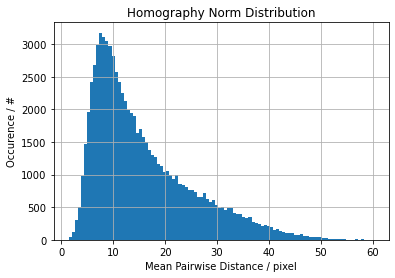

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# generate histogram of the norm of duv
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# running average
window = 10  # corresponds to one second at 5 fps
log_df['duv_mpd_ravg'] = log_df.duv_mpd.rolling(window).mean()
log_df.clip_idx -= window - 1  # adjust frame index to initial frame

hist = log_df.duv_mpd_ravg.hist(bins=100)
hist.set_title('Homography Norm Distribution')
hist.set_xlabel('Mean Pairwise Distance / pixel')
hist.set_ylabel('Occurence / #')
log_df

 - Sample videos at the extreme ends of the motion distribtion, i.e at `< th1` and `> th2`
 - Visualize these sample videos

In [14]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotmap import DotMap
from kornia import tensor_to_image
import sys

sys.path.append('../')

from datasets import VideoDataset
from utils.io import load_yaml, load_pickle

# sample videos with supposedly little and plenty motion
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# running average
window = 30  # corresponds to 6 seconds at 5 fps
log_df['duv_mpd_ravg'] = log_df.duv_mpd.rolling(window).mean()
log_df.clip_idx -= window - 1  # adjust frame index to initial frame

# threshold
th1 = 5.
th2 = 40.

weak_motion_df = log_df[log_df.duv_mpd_ravg < th1]
strong_motion_df = log_df[log_df.duv_mpd_ravg > th2]

# randomly sample weak and strong motion clips
n = 10
weak_motion_samples = weak_motion_df.sample(n=n, random_state=42)
strong_motion_samples = strong_motion_df.sample(n=n, random_state=42)

# get configs for video paths
server = 'local'
servers = load_yaml('../configs/servers.yml')
server = DotMap(servers[server])

configs = 'predictive_horizon_dgx.yml'
configs = load_yaml(os.path.join(server.config.location, configs))
configs = DotMap(configs)

n_vids = 6
meta_df = pd.read_pickle(os.path.join(server.config.location, configs.data.meta_df))[configs.data.subset_length:configs.data.subset_length+n_vids]
meta_df.train = False  # artificially set to test set
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]

# show randomly sampled clips
frame_rate = log_df.attrs['frame_rate']
clip_length_in_frames = window
frames_between_clips = log_df.attrs['frames_between_clips']
num_workers = 8

for (_, weak_motion_sample), (_, strong_motion_sample) in zip(weak_motion_samples.iterrows(), strong_motion_samples.iterrows()):
    print('Loading videos:\n{}\n{}'.format(test_video_paths[weak_motion_sample.vid_idx], test_video_paths[strong_motion_sample.vid_idx]))

    # load video meta data
    log_df.attrs['meta_data']['video_paths'] = [
        os.path.join(server.database.location, *x.split('/')[-3:]) for x in log_df.attrs['meta_data']['video_paths']  # change video paths (depends on server)
    ]
    test_metadata = log_df.attrs['meta_data']

    vid_ds = VideoDataset(
        video_paths=test_video_paths,
        clip_length_in_frames=clip_length_in_frames,
        frames_between_clips=frames_between_clips,
        precomputed_metadata=test_metadata,
        frame_rate=frame_rate,
        num_workers=num_workers,
        pre_transforms=[None for _ in range(len(test_video_paths))],
        aug_transforms=[None for _ in range(len(test_video_paths))],
        seeds=True
    )

    weak_clip, aug, fr, vid_fps, vid_idx, clip_idx = vid_ds[weak_motion_sample.clip_idx]
    strong_clip, aug, fr, vid_fps, vid_idx, clip_idx = vid_ds[strong_motion_sample.clip_idx]

    for weak_frame, strong_frame in zip(weak_clip, strong_clip):
        weak_frame, strong_frame = tensor_to_image(weak_frame), tensor_to_image(strong_frame)
        cv2.imshow('weak_motion', weak_frame[...,::-1])
        cv2.imshow('strong_motion', strong_frame[...,::-1])
        cv2.waitKey()
cv2.destroyAllWindows()


Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video72.mp4
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video71.mp4
/home/martin/miniconda3/envs/hil/lib/python3.7/site-packages/torchvision/io/video.py:116: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  "The pts_unit 'pts' gives wrong results and will be removed in a "
Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video69.mp4
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video71.mp4
Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video69.mp4
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video71.mp4
Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video67.mp4
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video71.mp4
Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/

 - Find when there is strong motion and whether there is a correlation to the phase

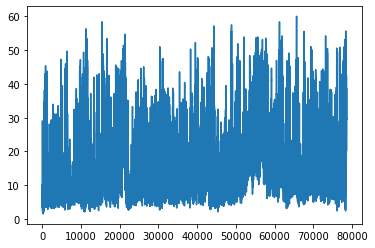

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# generate histogram of the norm of duv
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# sample one video
vid_idx = 10
single_vid_df = log_df[log_df.vid_idx == vid_idx]
single_vid_df = single_vid_df.reset_index()

single_vid_df['duv_mpd'] = single_vid_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# running average
window = 10  # corresponds to one second at 5 fps
single_vid_df['duv_mpd_ravg'] = single_vid_df.duv_mpd.rolling(window).mean()
single_vid_df.clip_idx -= window - 1  # adjust frame index to initial frame

# plot 
th1 = 5.
plt.plot(
    single_vid_df[single_vid_df.duv_mpd_ravg < 5.].index/(single_vid_df.attrs['meta_data']['video_fps'][0]-1)*(single_vid_df.attrs['frame_rate']-1), 
    single_vid_df[single_vid_df.duv_mpd_ravg < 5.].duv_mpd_ravg
)

plt.plot(
    single_vid_df[single_vid_df.duv_mpd_ravg > 5.].index/(single_vid_df.attrs['meta_data']['video_fps'][0]-1)*(single_vid_df.attrs['frame_rate']-1), 
    single_vid_df[single_vid_df.duv_mpd_ravg > 5.].duv_mpd_ravg
)
plt.show()
